# Assignment V
**DNNs**
Fecha: 18 de octubre, 2025

**Instrucciones:** Suba sus soluciones en un archivo comprimido a Classroom antes del 28 de octubre.


## Problema 1

Lea [1] hasta la sección cinco para entender cómo se usa backpropagation para calcular el gradiente de una red neuronal respecto a sus parámetros. Luego, codifique un script en PyTorch para resolver un problema de clasificación o regresión de alguna tarea anterior, pero esta vez usando backpropagation para calcular los gradientes. Compare los resultados que obtiene con backpropagation y usando diferenciación automática. Anote sus conclusiones.









x.shape: torch.Size([1000, 1])
X_poly.shape: torch.Size([1000, 9])
y.shape: torch.Size([1000, 1])
[Manual] Epoch 1/40000 Loss: 4.036477e+00
[Manual] Epoch 100/40000 Loss: 8.835230e-01
[Manual] Epoch 200/40000 Loss: 8.765436e-01
[Manual] Epoch 300/40000 Loss: 8.702353e-01
[Manual] Epoch 400/40000 Loss: 8.643735e-01
[Manual] Epoch 500/40000 Loss: 8.588541e-01
[Manual] Epoch 600/40000 Loss: 8.536035e-01
[Manual] Epoch 700/40000 Loss: 8.485679e-01
[Manual] Epoch 800/40000 Loss: 8.437056e-01
[Manual] Epoch 900/40000 Loss: 8.389850e-01
[Manual] Epoch 1000/40000 Loss: 8.343813e-01
[Manual] Epoch 1100/40000 Loss: 8.298754e-01
[Manual] Epoch 1200/40000 Loss: 8.254520e-01
[Manual] Epoch 1300/40000 Loss: 8.210996e-01
[Manual] Epoch 1400/40000 Loss: 8.168089e-01
[Manual] Epoch 1500/40000 Loss: 8.125727e-01
[Manual] Epoch 1600/40000 Loss: 8.083853e-01
[Manual] Epoch 1700/40000 Loss: 8.042423e-01
[Manual] Epoch 1800/40000 Loss: 8.001400e-01
[Manual] Epoch 1900/40000 Loss: 7.960758e-01
[Manual] Epoch

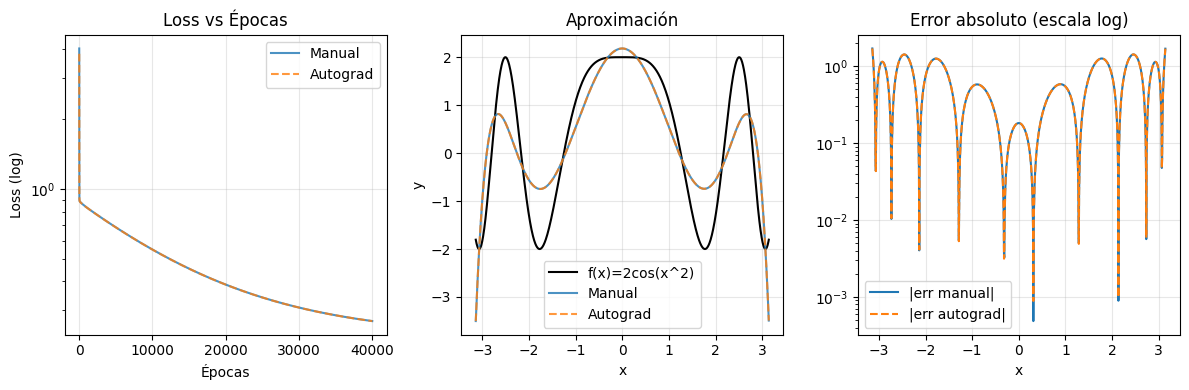


Resultados finales:
Val MSE manual:   2.699857e-01
Val MSE autograd: 2.699262e-01
Tiempo manual:   19.25 s
Tiempo autograd: 67.95 s


In [48]:
import math, time
import torch, torch.nn as nn, torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

# --------------------
# Datos
# --------------------
x = torch.linspace(-math.pi, math.pi, 1000, device=device).unsqueeze(1)
y = 2 * torch.cos(x ** 2)

x_norm = x / math.pi

grado = 8
X_poly = torch.hstack([x_norm**i for i in range(grado+1)])

# Verificación de formas
print("x.shape:", x.shape)
print("X_poly.shape:", X_poly.shape)
print("y.shape:", y.shape)

# --------------------
# Inicialización
# --------------------
theta_init = torch.randn(grado+1, 1, device=device)
theta = theta_init.clone().detach()

lr = 1e-1
num_epochs = 40000
log_every = 100

train_losses_manual = []

t0 = time.time()
for epoch in range(num_epochs):
    y_pred = X_poly @ theta
    err = y_pred - y
    loss = 0.5 * (err**2).mean()
    train_losses_manual.append(loss.item())

    grad = (X_poly.T @ err) / X_poly.shape[0]
    theta = theta - lr * grad

    if (epoch == 0) or ((epoch+1) % log_every == 0):
        print(f"[Manual] Epoch {epoch+1}/{num_epochs} Loss: {loss.item():.6e}")

t_manual = time.time() - t0
print(f"⏱️ Tiempo total (manual): {t_manual:.2f} s")

model = nn.Linear(grado+1, 1, bias=True).to(device)
with torch.no_grad():
    model.weight.copy_(theta_init.view(1, -1))

optimizer = optim.SGD(model.parameters(), lr=lr)
train_losses_auto = []

print('\n🔹 Iniciando entrenamiento autograd (nn.Linear + SGD)')
t0 = time.time()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_poly)
    loss = 0.5 * ((outputs - y)**2).mean()
    loss.backward()
    optimizer.step()
    train_losses_auto.append(loss.item())

    if (epoch == 0) or ((epoch+1) % log_every == 0):
        print(f"[Autograd] Epoch {epoch+1}/{num_epochs}  Loss: {loss.item():.6e}")

t_auto = time.time() - t0
print(f"⏱️ Tiempo total (autograd): {t_auto:.2f} s")


with torch.no_grad():
    y_pred_manual = (X_poly @ theta).cpu().numpy().ravel()
    y_pred_auto = model(X_poly).cpu().numpy().ravel()
    x_cpu = x.cpu().numpy().ravel()
    y_cpu = y.cpu().numpy().ravel()

epochs_range = np.arange(1, len(train_losses_manual) + 1)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(epochs_range, train_losses_manual, label='Manual', alpha=0.8)
plt.plot(epochs_range, train_losses_auto, label='Autograd', alpha=0.8, linestyle='--')
plt.yscale('log')
plt.xlabel('Épocas')
plt.ylabel('Loss (log)')
plt.title('Loss vs Épocas')
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(1,3,2)
plt.plot(x_cpu, y_cpu, label='f(x)=2cos(x^2)', color='k')
plt.plot(x_cpu, y_pred_manual, label='Manual', alpha=0.8)
plt.plot(x_cpu, y_pred_auto, label='Autograd', alpha=0.8, linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Aproximación')
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(1,3,3)
err_manual = np.abs(y_cpu - y_pred_manual) + 1e-12
err_auto = np.abs(y_cpu - y_pred_auto) + 1e-12
plt.plot(x_cpu, err_manual, label='|err manual|')
plt.plot(x_cpu, err_auto, label='|err autograd|', linestyle='--')
plt.yscale('log')
plt.xlabel('x')
plt.title('Error absoluto (escala log)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --------------------
# Métricas finales
# --------------------
mse_manual = np.mean((y_cpu - y_pred_manual)**2) / 2.0
mse_auto = np.mean((y_cpu - y_pred_auto)**2) / 2.0

print('\nResultados finales:')
print(f'Val MSE manual:   {mse_manual:.6e}')
print(f'Val MSE autograd: {mse_auto:.6e}')
print(f'Tiempo manual:   {t_manual:.2f} s')
print(f'Tiempo autograd: {t_auto:.2f} s')


## **Conclusión**

La comparación demuestra que la diferenciación automática (autograd) en PyTorch es una implementación correcta y robusta del cálculo de gradientes (backpropagation), ya que produce resultados numéricos y de aproximación idénticos al gradiente calculado manualmente.

La ventaja de autograd es que simplifica un proceso de calculo generando un grafo equivalente a un backpropagation de manera automática, algo que visiblemente se ve que realiza en este caso que es más simple, una proximación polinomica pues se denota que autograd le cuesta bastante en temas temporales comparado con el backpropagation manual.

## Problema 2 — Referencia [1]
Referencia: Catherine F. Higham, Desmond J. Higham, "Deep Learning: An Introduction for Applied Mathematicians", SIAM, 2019.

**1) ¿Cuál es el problema crítico que el artículo intenta resolver? ¿Por qué es relevante resolverlo?**

El problema critico que el artículo intenta resolver, en este caso no existe, es un articulo que aborda la necesidad de explicar el aprendizaje profundo con matemáticas. Se centra en tres preguntas clave: ¿qué es una red neuronal profunda?, ¿cómo se entrena?, y ¿cómo funciona el descenso de gradiente estocástico (SGD)?

A su vez la importancia de este paper radica en que el aprendizaje profundo al revolucionar muchos campos, es necesario entender fundamentos matematicos para crear sistemas de aprendizaje robustos los cuales puedan ser explicados y entendidos.

**2) ¿Qué opina sobre la idea propuesta? ¿Qué ventajas y desventajas nota?**

Es un recurso pedagogico le cual emplea matematicas para explicar conceptos de aprendizaje profundo, lo cual es una ventaja ya que permite entender los fundamentos de las redes neuronales profundas.

Si se puede ver alguna desventaja quizá es el tema de que no es un artículo que propone una nueva idea o solución a un problema, sino que es más bien una revisión explicativa.

Su fortaleza es la claridad: presenta conceptos clave (arquitecturas de red, retropropagación, SGD) con ejemplos simples en MATLAB y demostraciones de software.

**3) ¿Cómo se pueden implementar esas ideas y usar en PyTorch? ¿Ya están implementadas (bibliotecas, funciones existentes)?**

Las ideas presentadas en el artículo se pueden implementar en PyTorch utilizando las funciones y módulos existentes para construir y entrenar redes neuronales profundas. PyTorch proporciona una amplia gama de herramientas para definir arquitecturas de redes, optimizar parámetros y realizar el descenso de gradiente estocástico.

```python
import torch
import torch.nn as nn
import torch.optim as optim


class SimpleNet(nn.Module):
def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.net = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.Sigmoid(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid())


def forward(self, x):
    return self.net(x)


model = SimpleNet(input_dim=2, hidden_dim=4, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)


for epoch in range(100):
    inputs = torch.randn(10, 2)
    labels = torch.randint(0, 2, (10,))
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```

**4) Identifique en qué circunstancias conviene aplicar la idea del artículo. ¿Cómo puede serle útil?**

La idea del artículo es útil en contextos educativos y de investigación donde se busca una comprensión más profunda de los fundamentos matemáticos del aprendizaje profundo. Puede ser especialmente valiosa para estudiantes y profesionales que deseen desarrollar modelos más robustos y explicables basados en el funcionamiento interno de las redes neuronales.


## Problema 3 — Referencia [2]
Referencia: G. Cybenko, "Approximation by superpositions of a sigmoidal function", 1989.

**1) ¿Cuál es el problema crítico que el artículo intenta resolver? ¿Por qué es relevante resolverlo?**

Cybenko plantea y resuleve el problema de la capacidad de las redes neuronales para aproximar funciones continuas. Demuestra que una red neuronal con una sola capa oculta y funciones de activación sigmoides puede aproximar cualquier función continua.

Proporciona lo que es una base teorica pues da certeza de la efectividad de las redes neuronales en tareas de aproximación de funciones, lo cual es fundamental para su aplicación en aprendizaje automático.

**2) ¿Qué opina sobre la idea propuesta? ¿Qué ventajas y desventajas nota?**

La idea de Cybenko es fundamental para establecer la base teórica del aprendizaje profundo. Una ventaja es que proporciona garantías sobre la capacidad de las redes neuronales para aproximar funciones complejas. Sin embargo, una desventaja es que no aborda la eficiencia computacional ni la necesidad de múltiples capas para funciones más complejas o la cantidad de nodos en la capa oculta que se necesitan para un caso concreto.

**3) ¿Cómo se pueden implementar esas ideas y usar en PyTorch? ¿Ya están implementadas (bibliotecas, funciones existentes)?**

Las ideas de Cybenko se pueden implementar en PyTorch utilizando redes neuronales con una sola capa oculta y funciones de activación sigmoides. PyTorch permite construir fácilmente estas arquitecturas y entrenarlas con datos.

```python
import torch
import torch.nn as nn
import torch.optim as optim


class SimpleNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


model = SimpleNet(input_dim=2, hidden_dim=4, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)


for epoch in range(100):
    inputs = torch.randn(10, 2)
    labels = torch.randint(0, 2, (10,))
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```

**4) Identifique en qué circunstancias conviene aplicar la idea del artículo. ¿Cómo puede serle útil?**

Cybenko demostró que una red neuronal **con una sola capa oculta y función sigmoide** puede aproximar **cualquier función continua**  

$$
f:[0,1]^n \to \mathbb{R}
$$

con precisión arbitraria:

$$
F(x)=\sum_{i=1}^{N}\alpha_i\,\sigma(w_i^T x+\theta_i)
\quad \text{tal que} \quad |F(x)-f(x)|<\varepsilon
$$

**Utilidad:**
- Las combinaciones de sigmoides forman una **base densa** en el espacio de funciones continuas.  
- Usa fundamentos del **Teorema de Hahn–Banach** y la **dualidad de Riesz**.  
- Es la **base teórica** del aprendizaje profundo: garantiza que las redes pueden modelar **cualquier relación compleja** entre variables.


## Problema 4 — Referencia [3]
Referencia: Maithra Raghu, et al., "On the expressive power of deep neural networks", ICML 2017.

**1) ¿Cuál es el problema crítico que el artículo intenta resolver? ¿Por qué es relevante resolverlo?**

El tema principal del articulo es presentar una justificación al mejor trabajo de una red profundo contra las redes poco profundas.

La relevancia radica en que presenta un trabajo el cual las redes profundas permiten representar funciones con una eficiencia mayor. Esto justifica el diseño de arquitecturas profundas en lugar de poco profundas.

**2) ¿Qué opina sobre la idea propuesta? ¿Qué ventajas y desventajas nota?**

ventajas:

- Justifica el uso de redes profundas.
- Introduce herramientas matemáticas (por ejemplo, trajectory length, Jacobian singular values) para analizar la complejidad de la transformación aprendida.
- Da intuiciones geométricas sobre cómo la profundidad permite modelar funciones con mayor flexibilidad.

Desventajas:
- El análisis es teórico y puede no capturar todos los aspectos prácticos del entrenamiento de redes profundas.
- No aborda recomendaciones específicas para arquitecturas o hiperparámetros.

**3) ¿Cómo se pueden implementar esas ideas y usar en PyTorch? ¿Ya están implementadas (bibliotecas, funciones existentes)?**

Las ideas del artículo se pueden implementar en PyTorch construyendo redes neuronales profundas y midiendo métricas como la longitud de trayectoria y los valores singulares del Jacobiano como se muestra a continuación:

- **jacobian**: Calcula la matriz Jacobiana de una función, es decir, todas las derivadas parciales de la salida respecto a la entrada. Útil para analizar cómo pequeños cambios en la entrada afectan la salida de la red.

- **jvp** (Jacobian-Vector Product): Calcula el producto de la Jacobiana por un vector dado, sin construir la matriz completa. Permite estimar cómo una dirección específica en el espacio de entrada afecta la salida.

- **vjp** (Vector-Jacobian Product): Calcula el producto de un vector por la Jacobiana (transpuesta), útil para propagación hacia atrás (backpropagation) y para obtener gradientes eficientes respecto a la entrada.

```python

import torch
import torch.nn as nn
from torch.autograd.functional import jacobian, jvp, vjp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Modelo de ejemplo pequeño
model = nn.Sequential(nn.Linear(3, 16), nn.ReLU(), nn.Linear(16, 2)).to(device)
model.eval()

# Punto de entrada (requiere grad para jvp/vjp)
x = torch.randn(1, 3, device=device, requires_grad=True)

# --- Método 1: jacobian + svdvals (directo) ---
def singular_values_via_jacobian(model, x):
    def f(inp):
        return model(inp).view(-1)
    J = jacobian(f, x)
    J = J.reshape(J.shape[0], -1).detach()
    s = torch.linalg.svdvals(J)
    return s, J

s_vals, Jmat = singular_values_via_jacobian(model, x)
print('Valores singulares (directo):', s_vals.cpu().numpy())

# --- Método 2: estimar mayor valor singular con power method usando JVP/VJP ---
def largest_singular_power_method(model, x, iters=20):
    def f(inp):
        return model(inp).view(-1)
    v = torch.randn_like(x)
    v = v / (v.norm()+1e-12)
    sigma = None
    for _ in range(iters):
        _, jv = jvp(f, x, v)
        u = jv
        u_norm = u.norm()+1e-12
        u = u / u_norm
        _, v_cot = vjp(f, x, u)
        v = v_cot[0].reshape_as(x)  
        v = v / (v.norm()+1e-12)
        sigma = u_norm
    return sigma, u, v

sigma_est, u_vec, v_vec = largest_singular_power_method(model, x, iters=30)
print('Mayor valor singular estimado (power):', float(sigma_est))

# --- Longitud de trayectoria (discretizada) ---
def trajectory_length(model, x0, x1, steps=100):
    t = torch.linspace(0., 1., steps, device=x0.device)
    xs = x0 * (1 - t).unsqueeze(-1) + x1 * t.unsqueeze(-1)
    with torch.no_grad():
        ys = model(xs)
    diffs = ys[1:] - ys[:-1]
    seg_lengths = torch.norm(diffs.reshape(diffs.shape[0], -1), dim=1)
    return float(seg_lengths.sum().cpu().item())

x0 = torch.randn(1,3, device=device)
x1 = torch.randn(1,3, device=device)
L = trajectory_length(model, x0, x1, steps=200)
print('Longitud de trayectoria (discretizada):', L)
```


## Problema 5 — Referencia [4]
Referencia: Shiv Ram Dubey, Satish Kumar Singh, Bidyut Baran Chaudhuri, "Activation Functions in Deep Learning: A Comprehensive Survey and Benchmark", arXiv 2021.

**1) ¿Cuál es el problema crítico que el artículo intenta resolver? ¿Por qué es relevante resolverlo?**

El problema principal es la siguiente pregunta:

¿cómo afecta la elección de la función de activación al entrenamiento, la estabilidad y el rendimiento de una red neuronal?

Es de alta relevancia pues las funciones de activación son el alma para que la redes neuronales aprendan representaciones no lineales complejas. Elegir adecuadamente mi función de activación puede mejorar las metricas, convergencia y estabilidad del entrenamiento. Además, evitar el gradiente desvanecido.

Basicamente es un benchmark de 18 funciones de activación.

**2) ¿Qué opina sobre la idea propuesta? ¿Qué ventajas y desventajas nota?**

No propone un nuevo metodo pero si el análisis comparativo de muchas funciones de activación existentes.

Tanh/sigmoid: eran populares al principio pero se reconoció saturación y gradiente desvanecido.

ReLu y sus variantes (LeakyReLU, PReLU, ELU) son ampliamente usadas por su simplicidad y eficiencia computacional. Pero tienen problemas como "neuronas muertas".

Exponential/ELU: permiten valores negativos, ayudando a centrar datos y acelerar convergencia.

Adaptive/lerneable AFs: PReLU, Swish, Mish ajustan su forma durante el entrenamiento, potencialmente mejorando rendimiento.

Ventajas:
- Proporciona una visión integral de las funciones de activación y esta actualizado.

Desventajas:
- Como encuesta, no propone nuevas funciones o técnicas.

**3) ¿Cómo se pueden implementar esas ideas y usar en PyTorch? ¿Ya están implementadas (bibliotecas, funciones existentes)?**

PyTorch, a través de sus módulos torch.nn y el espacio de nombres torch.nn.functional, proporciona la mayoría de las funciones de activación mencionadas en el artículo.

```python
import torch
import torch.nn as nn
import torch.nn.functional as F


class CustomNet(nn.Module):
    def __init__(self, activation_fn):
        super(CustomNet, self).__init__()
        self.fc1 = nn.Linear(10, 20)
        self.activation = activation_fn
        self.fc2 = nn.Linear(20, 5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

# Instanciar modelos con diferentes funciones de activación
model_sigmoid = CustomNet(activation_fn=nn.Sigmoid())
model_tanh = CustomNet(activation_fn=nn.Tanh())
model_leaky_relu = CustomNet(activation_fn=nn.LeakyReLU(negative_slope=0.01))
model_elu = CustomNet(activation_fn=nn.ELU(alpha=1.0))
model_swish = CustomNet(activation_fn=nn.SiLU()) # SiLU es el nombre de Swish en PyTorch
model_mish = CustomNet(activation_fn=nn.Mish()) # Mish está disponible en versiones recientes
```

**4) ¿Identifique en qué circunstancias conviene aplicar la idea del artículo. ¿Cómo puede serle útil?**

Principalmente a la hora de elegir una configuración para una red neuronal, ya que la función de activación puede tener un impacto significativo en el rendimiento del modelo.

Dando herramientas para tener un contexto y entendimiento de las funciones de activación y sus efectos en el entrenamiento y desempeño del modelo.

Por ejemplo: Podemos hablar de ReLu que es un estandar en muchas arquitecturas por su simplicidad y eficiencia, pero en casos donde se enfrentan problemas de "neuronas muertas", podríamos considerar LeakyReLU o PReLU. Si buscamos una función que permita valores negativos y ayude a centrar los datos, ELU podría ser una mejor opción.

## Problema 6 — Referencia [5]
Referencia: Prajit Ramachandran, Barret Zoph, Quoc V. Le, "Searching for Activation Functions", arXiv 2017.

**1) ¿Cuál es el problema crítico que el artículo intenta resolver? ¿Por qué es relevante resolverlo?**

El problema que aborda el articulo es parecido al anterior, pero en este caso se enfoca en la búsqueda automática de nuevas funciones de activación que puedan superar a las existentes.

Definieron un espacio de búsqueda compuesto por un conjunto de "bloques de construcción" simples: funciones unarias (como la identidad, el seno, la exponencial) y funciones binarias (como la suma, el producto, la resta). Luego, utilizaron dos estrategias de búsqueda para combinar estos bloques y formar nuevas funciones candidatas:

1. **Búsqueda aleatoria**: Para espacios de búsqueda pequeños, simplemente probaron todas las combinaciones posibles.

2. **Aprendizaje por refuerzo**: Para espacios más grandes y complejos, se diseño un modelo de aprendizaje por refuerzo que generaba secuencias de bloques de construcción. La recompensa para el agente de RL se basaba en el rendimiento de la función de activación generada en un conjunto de validación.

**2) ¿Qué opina sobre la idea propuesta? ¿Qué ventajas y desventajas nota?**

Pienso que la idea propuesta es  sumamente interesante pues permite explorar funciones de activación de frontera al conocimiento actual.

De esta investigación surgio la función de activación "Swish", definida como:
$$
\text{Swish}(x) = x \cdot \sigma(x) = \
x \cdot \frac{1}{1 + e^{-x}}
$$

Una función según los autores, simple, pero altamente efectiva.

**3) ¿Cómo se pueden implementar esas ideas y usar en PyTorch? ¿Ya están implementadas (bibliotecas, funciones existentes)?**

Al día de hoy si existe la posibilidad de usar Swish en PyTorch, ya que está implementada como **nn.SiLU()**.

```python
import torch
import torch.nn as nn
import torch.nn.functional as F
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        self.fc1 = nn.Linear(10, 20)
        self.activation = nn.SiLU()  # Swish
        self.fc2 = nn.Linear(20, 5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x
```


**4) Identifique en qué circunstancias conviene aplicar la idea del artículo. ¿Cómo puede serle útil?**

En una aplicación practica queda bastante claro que este metodo utilizado demuestra que no solo los parametros de red puede ser optimizados, sino tambien la arquitectura y funciones internas de la red.

A lo que dice el paper, la función Swish ha sido capaz de superar a ReLU en varias tareas y arquitecturas, especialmente en redes profundas.

Derivada de Swish: La derivada de Swish es esencial para la retropropagación y muestra cómo la función ayuda al flujo de gradientes:
$$f'(x) = \sigma(\beta x) + \beta x \cdot \sigma(\beta x)(1 - \sigma(\beta x))$$
Se puede reescribir como:
$$f'(x) = \sigma(\beta x) + \beta f(x) (1 - \sigma(\beta x))$$
A diferencia de ReLU, cuya derivada es 0 para todas las entradas negativas, la derivada de Swish no es cero para valores negativos, lo que ayuda a evitar el problema de las "neuronas muertas" y permite que los gradientes fluyan más eficazmente durante el entrenamiento.

## Problema 7 — Referencia [6]
Referencia: Sergey Ioffe, Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift", ICML 2015.

1) ¿Cuál es el problema crítico que el artículo intenta resolver? ¿Por qué es relevante resolverlo?

El entrenar redes profundas tiende a la inestabilidad debido al "desplazamiento covariante interno", su significacdo es el siguiente:

A medida que se actualizan los pesos en el entrenamiento, la distribución de las activaciones en cada capa cambia, lo que dificulta el aprendizaje. Esto obliga a usar tasas de aprendizaje más bajas y una inicialización cuidadosa de los pesos, lo que dificulta la convergencia y aumenta el tiempo empleado en entrenar modelos profundos.

2) ¿Qué opina sobre la idea propuesta? ¿Qué ventajas y desventajas nota?

La idea propuesta es interesante, presenta el Batch Normalization (BN) como una técnica para mitigar el desplazamiento covariante interno. Normaliza explícitamente las entradas de cada capa para cada mini-lote durante el entrenamiento. Específicamente, para cada característica (o canal en una capa convolucional), la capa BN calcula la media y la varianza de esa característica a través de las muestras del mini-lote y luego la normaliza para que tenga media cero y varianza unitaria.

Quiza una desventaja es la inclusión de 2 nuevos hiperparámetros (gamma y beta) que deben ser aprendidos durante el entrenamiento, además de que el comportamiento de BN puede ser diferente durante el entrenamiento y la inferencia, lo que requiere un manejo cuidadoso.

Matematicamente se pidría expresar como:
$$
\hat{x}^{(k)} = \frac{x^{(k)} - \mu_B^{(k)}}{\sqrt{(\sigma_B^{(k)})^2 + \epsilon}}
$$
$$
y^{(k)} = \gamma^{(k)} \hat{x}^{(k)} + \beta^{(k)}
$$

donde:
- $x^{(k)}$ es la activación de la característica $k$
- $ \mu_B^{(k)} $ es la media del mini-lote para la característica $ k $
- $ (\sigma_B^{(k)})^2 $ es la varianza del mini-lote para la característica $ k $
- $ \epsilon $ es un pequeño valor para evitar la división por cero
- $ \gamma^{(k)} $ y $ \beta^{(k)} $ son parámetros aprendibles que permiten a la red recuperar la capacidad de representación completa.



3) ¿Cómo se pueden implementar esas ideas y usar en PyTorch? ¿Ya están implementadas (bibliotecas, funciones existentes)?

PyTorch ofrece implementaciones altamente optimizadas de Batch Normalization para diferentes tipos de datos: nn.BatchNorm1d para datos vectoriales (como en un MLP) y nn.BatchNorm2d para datos de imagen (como en una CNN).

Se menciona en el paper que lo mejor es colocar la capa de normalización justo después de la capa lineal o convolucional y antes de la función de activación.

```python
import torch.nn as nn

# Ejemplo de un bloque convolucional en una CNN
conv_block_with_bn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(num_features=64), # Normaliza a través de los 64 canales
    nn.ReLU()
)

# Ejemplo en un MLP
mlp_block_with_bn = nn.Sequential(
    nn.Linear(in_features=128, out_features=256),
    nn.BatchNorm1d(num_features=256),
    nn.ReLU()
)
```

4) ¿Identifique en qué circunstancias conviene aplicar la idea del artículo. ¿Cómo puede serle útil?

Esta técnica mencionada en el paper puede ser verdaderamente util en casi cualquier circunstancia donde se entrenen redes neuronales profundas, especialmente en arquitecturas muy profundas o cuando se utilicen tasas de aprendizaje relativamente altas. 

BatchNormalization puede llegar a acelerar la convergencia del entrenamiento, y mejorar la estabilidad de entrenamiento.

El artículo demostró que un modelo de última generación en ImageNet podía alcanzar la misma precisión con 14 veces menos pasos de entrenamiento al usar BN


## Problema 8 — Referencia [7]
Referencia: Shibani Santurkar, Dimitris Tsipras, Andrew Ilyas, Aleksander Madry, "How Does Batch Normalization Help Optimization?", NeurIPS 2018.

**1) ¿Cuál es el problema crítico que el artículo intenta resolver? ¿Por qué es relevante resolverlo?**

A pesar de la alta adopción de el BN, no existía un comprensión empírica formal la cual explique por qué BN mejora la optimización y generalización de las redes neuronales profundas.

Sobre todo si la reducción de la ICS (Internal Covariate Shift) es la razón principal por la cual BN ayuda en el entrenamiento.

La importancia de resolver esto es dar una explicación causal por la cual BN funciona y abrir puertas a nuevas técnicas dado el resultado causal de su estudio.

**2) ¿Qué opina sobre la idea propuesta? ¿Qué ventajas y desventajas nota?**

Es interesante el tema de que el ICS no es la razón principal por la cual BN ayuda en el entrenamiento, sino que más bien BN mejora la suavidad del paisaje de optimización.    

Implica varias cosas, que la función de perdida sea más "predecible" y que los gradientes sean más informativos. Un gradiente más informativo significa que el paso dado por el optimizador es más probable que reduzca la función de pérdida de manera efectiva.

**3) ¿Cómo se pueden implementar esas ideas y usar en PyTorch? ¿Ya están implementadas (bibliotecas, funciones existentes)?**

El batch normalization ya está implementado en PyTorch a través de las clases `nn.BatchNorm1d`, `nn.BatchNorm2d` y `nn.BatchNorm3d`, dependiendo del tipo de datos que se estén utilizando (1D para datos vectoriales, 2D para imágenes y 3D para videos o volúmenes).

La forma en la cual podemos ver la suavidad del paisaje de optimización es observando la norma del gradiente durante el entrenamiento. Un paisaje más suave debería mostrar gradientes con normas más pequeñas y menos variabilidad.

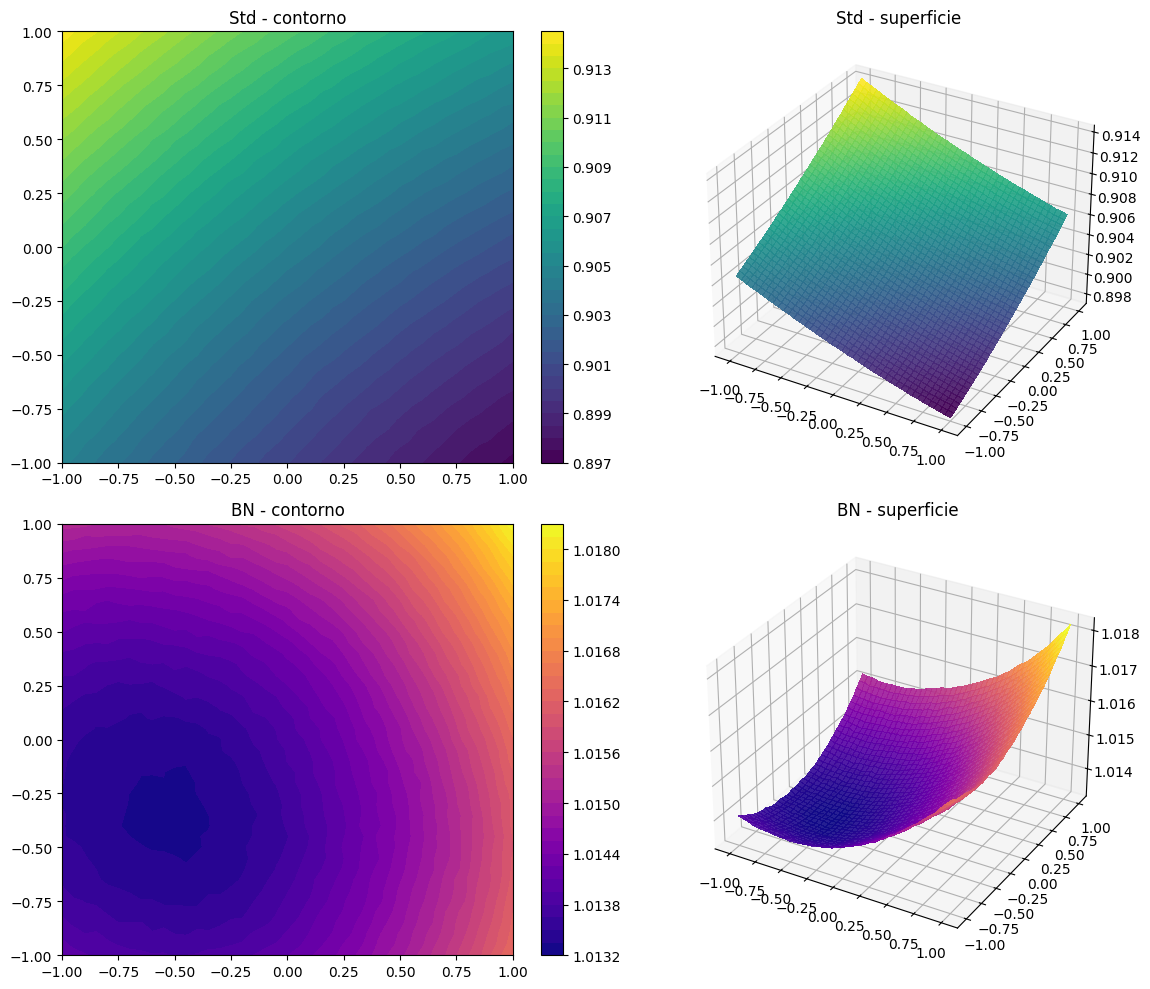

```python




In [ ]:
# Visualizar paisaje de pérdida (CIFAR-10): comparar modelo estándar vs con BatchNorm
import time, math
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
import torchvision, torchvision.transforms as T
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
np.random.seed(0)


transform = T.Compose([T.ToTensor(), T.Normalize((0.4914,0.4822,0.4465),(0.2470,0.2435,0.2616))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=512, shuffle=False, num_workers=2)


def make_net(use_bn=False):
    layers = []
    layers += [nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(inplace=True)]
    if use_bn: layers += [nn.BatchNorm2d(32)]
    layers += [nn.MaxPool2d(2)]
    layers += [nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True)]
    if use_bn: layers += [nn.BatchNorm2d(64)]
    layers += [nn.MaxPool2d(2)]
    return nn.Sequential(
        *layers,
        nn.Flatten(),
        nn.Linear(64*8*8, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, 10)
    )

def train_model(model, epochs=10, lr=1e-3):
    model.to(device)
    opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    crit = nn.CrossEntropyLoss()
    model.train()
    for ep in range(epochs):
        t0 = time.time()
        running = 0.0
        for xb, yb in trainloader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb)
            loss = crit(out, yb)
            loss.backward()
            opt.step()
            running += loss.item() * xb.size(0)
        print(f"ep {ep+1}/{epochs} loss {running/len(trainset):.4f} time {time.time()-t0:.1f}s")
    return model

# Flatten/unflatten parameters
def params_to_vector(model):
    return torch.cat([p.detach().view(-1) for p in model.parameters()]).cpu()

def vector_to_params(model, vec):
    vec = vec.to(next(model.parameters()).device)
    offset = 0
    with torch.no_grad():
        for p in model.parameters():
            num = p.numel()
            p.copy_(vec[offset:offset+num].view_as(p))
            offset += num


def copy_running_stats(src_model, tgt_model):
    """
    Copy buffer tensors (like running_mean/running_var) from src_model to tgt_model when names match.
    Does not touch parameters (weights/bias), only buffers.
    """
    src_buffers = dict(src_model.named_buffers())
    tgt_buffers = dict(tgt_model.named_buffers())
    for name, buf in src_buffers.items():
        if name in tgt_buffers:
            try:
                tgt_buffers[name].data.copy_(buf.data)
            except Exception:
                # ignore mismatches
                pass



def compute_smoothness_metrics(loss_grid):
    # gradients along each axis
    gx, gy = np.gradient(loss_grid)
    grad_mag = np.sqrt(gx**2 + gy**2)
    return {
        'grad_mean': float(np.mean(grad_mag)),
        'grad_std': float(np.std(grad_mag)),
        'loss_min': float(np.min(loss_grid)),
        'loss_max': float(np.max(loss_grid)),
    }

# Eval loss on test set (average)
def eval_loss_from_vector(model, vec, dataloader, crit):
    vector_to_params(model, vec)
    model.eval()
    total = 0.0
    n = 0
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            total += crit(out, yb).item() * xb.size(0)
            n += xb.size(0)
    return total / n


print("Entrenando modelo estándar")
std = make_net(use_bn=False)
std = train_model(std, epochs=8, lr=1e-2)

print("\nEntrenando modelo con BatchNorm")
bn = make_net(use_bn=True)
bn = train_model(bn, epochs=8, lr=1e-2)

theta_std = params_to_vector(std)
theta_bn  = params_to_vector(bn)

crit = nn.CrossEntropyLoss(reduction='mean')

def make_dirs(vec_dim, scale=1.0):
    d1 = torch.randn(vec_dim)
    d2 = torch.randn(vec_dim)
    # ortogonalizar d2 vs d1
    d2 = d2 - (d2.dot(d1) / (d1.dot(d1)+1e-12)) * d1
    # normalizar
    d1 = d1 / (d1.norm()+1e-12)
    d2 = d2 / (d2.norm()+1e-12)
    return d1 * scale, d2 * scale

scale = 1.0  # controla magnitud de perturbaciones
d1_std, d2_std = make_dirs(theta_std.numel(), scale=scale)
d1_bn, d2_bn   = make_dirs(theta_bn.numel(),  scale=scale)

# función para construir malla y evaluar pérdidas
def grid_loss(theta_star, base_model, d1, d2, alphas, betas, dataloader, crit, subset_batches=10):
    # option: evaluate on smaller subset for speed => construct a small loader
    reduced = []
    it = iter(dataloader)
    for _ in range(subset_batches):
        try:
            reduced.append(next(it))
        except StopIteration:
            break
    small_loader = reduced if reduced else list(dataloader)
    losses = np.zeros((len(alphas), len(betas)))
    theta_star = theta_star.clone()
    for i, a in enumerate(alphas):
        for j, b in enumerate(betas):
            vec = theta_star + a * d1 + b * d2
            # set params and eval on small_loader
            vector_to_params(base_model, vec)
            base_model.eval()
            total = 0.0
            n = 0
            with torch.no_grad():
                for xb, yb in small_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    out = base_model(xb)
                    total += crit(out, yb).item() * xb.size(0)
                    n += xb.size(0)
            losses[i, j] = total / n
    return losses


Entrenando modelo estándar
ep 1/8 loss 1.5404 time 20.5s
ep 1/8 loss 1.5404 time 20.5s
ep 2/8 loss 1.0949 time 21.0s
ep 2/8 loss 1.0949 time 21.0s
ep 3/8 loss 0.9061 time 20.8s
ep 3/8 loss 0.9061 time 20.8s
ep 4/8 loss 0.7757 time 23.6s
ep 4/8 loss 0.7757 time 23.6s
ep 5/8 loss 0.6684 time 23.8s
ep 5/8 loss 0.6684 time 23.8s
ep 6/8 loss 0.5695 time 21.1s
ep 6/8 loss 0.5695 time 21.1s
ep 7/8 loss 0.4611 time 20.9s
ep 7/8 loss 0.4611 time 20.9s
ep 8/8 loss 0.3699 time 21.1s

Entrenando modelo con BatchNorm
ep 8/8 loss 0.3699 time 21.1s

Entrenando modelo con BatchNorm
ep 1/8 loss 1.1804 time 20.6s
ep 1/8 loss 1.1804 time 20.6s
ep 2/8 loss 0.7953 time 20.4s
ep 2/8 loss 0.7953 time 20.4s
ep 3/8 loss 0.5971 time 20.3s
ep 3/8 loss 0.5971 time 20.3s
ep 4/8 loss 0.4209 time 20.2s
ep 4/8 loss 0.4209 time 20.2s
ep 5/8 loss 0.2698 time 23.5s
ep 5/8 loss 0.2698 time 23.5s
ep 6/8 loss 0.1571 time 21.1s
ep 6/8 loss 0.1571 time 21.1s
ep 7/8 loss 0.0789 time 20.1s
ep 7/8 loss 0.0789 time 20.1s
ep 8/8 


Evaluando grid para modelo estándar (usa subset de test para rapidez)
Evaluando grid para modelo BatchNorm
Evaluando grid para modelo BatchNorm


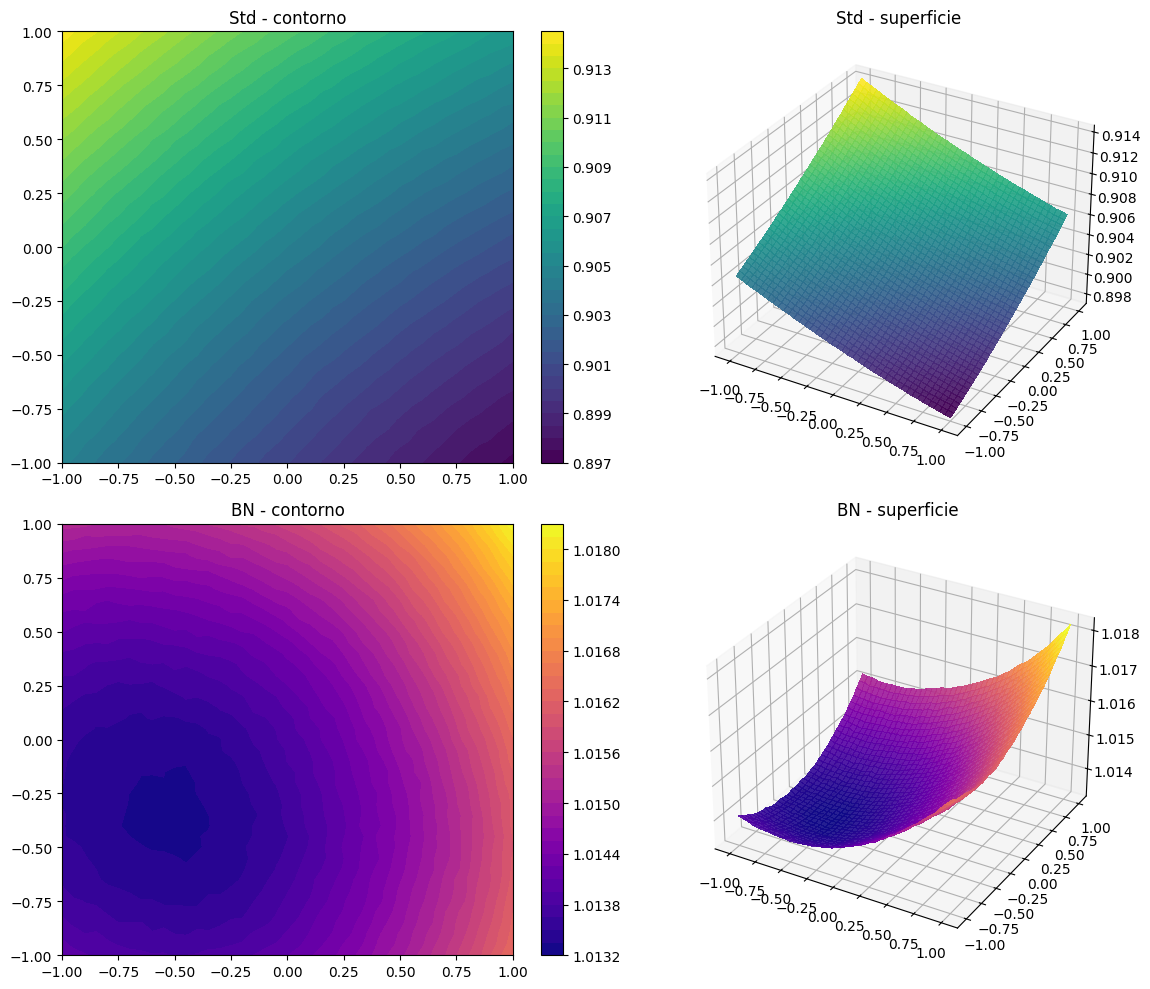

Std loss grid: min 0.8974  max 0.9143  std 0.003575
BN  loss grid: min 1.0133  max 1.0183  std 0.001041

Suavidad (Std): grad_mean=3.026438e-04 grad_std=4.247183e-05 loss_min=8.973771e-01 loss_max=9.142914e-01
Suavidad (BN) : grad_mean=1.084224e-04 grad_std=5.290486e-05 loss_min=1.013286e+00 loss_max=1.018252e+00


In [ ]:
# grid definition
grid_n = 41
alphas = np.linspace(-1.0, 1.0, grid_n)
betas  = np.linspace(-1.0, 1.0, grid_n)

print("\nEvaluando grid para modelo estándar (usa subset de test para rapidez)")
std_copy = make_net(use_bn=False).to(device)
loss_std_grid = grid_loss(theta_std, std_copy, d1_std, d2_std, alphas, betas, testloader, crit, subset_batches=6)

print("Evaluando grid para modelo BatchNorm")
bn_copy = make_net(use_bn=True).to(device)
copy_running_stats(bn, bn_copy)
loss_bn_grid = grid_loss(theta_bn, bn_copy, d1_bn, d2_bn, alphas, betas, testloader, crit, subset_batches=6)

A, B = np.meshgrid(alphas, betas)
fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(2,2,1)
cs1 = ax1.contourf(A, B, loss_std_grid.T, levels=40, cmap='viridis')
ax1.set_title('Std - contorno')
fig.colorbar(cs1, ax=ax1)

ax2 = fig.add_subplot(2,2,2, projection='3d')
ax2.plot_surface(A, B, loss_std_grid.T, cmap='viridis', linewidth=0, antialiased=False, alpha=0.9)
ax2.set_title('Std - superficie')

ax3 = fig.add_subplot(2,2,3)
cs3 = ax3.contourf(A, B, loss_bn_grid.T, levels=40, cmap='plasma')
ax3.set_title('BN - contorno')
fig.colorbar(cs3, ax=ax3)

ax4 = fig.add_subplot(2,2,4, projection='3d')
ax4.plot_surface(A, B, loss_bn_grid.T, cmap='plasma', linewidth=0, antialiased=False, alpha=0.9)
ax4.set_title('BN - superficie')

plt.tight_layout()
plt.show()

# Observación rápida: comparar estadísticas
print("Std loss grid: min %.4f  max %.4f  std %.6f" % (loss_std_grid.min(), loss_std_grid.max(), loss_std_grid.std()))
print("BN  loss grid: min %.4f  max %.4f  std %.6f" % (loss_bn_grid.min(), loss_bn_grid.max(), loss_bn_grid.std()))

# métricas objetivas de suavidad (gradientes sobre la rejilla)
metrics_std = compute_smoothness_metrics(loss_std_grid)
metrics_bn  = compute_smoothness_metrics(loss_bn_grid)
print('\nSuavidad (Std): grad_mean={:.6e} grad_std={:.6e} loss_min={:.6e} loss_max={:.6e}'.format(metrics_std['grad_mean'], metrics_std['grad_std'], metrics_std['loss_min'], metrics_std['loss_max']))
print('Suavidad (BN) : grad_mean={:.6e} grad_std={:.6e} loss_min={:.6e} loss_max={:.6e}'.format(metrics_bn['grad_mean'], metrics_bn['grad_std'], metrics_bn['loss_min'], metrics_bn['loss_max']))


**4) ¿Identifique en qué circunstancias conviene aplicar la idea del artículo. ¿Cómo puede serle útil?**

Es un cambio de paradigma que suele ocurrrir en la investigación científica, donde una explicación ampliamente aceptada es desafiada por nuevos hallazgos. En este caso el efecto causal de BN y su efectividad en la optimización y generalización de las redes neuronales profundas.


## Problema 9 — Referencia [8]
Referencia: Siddharth Krishna Kumar, "On weight initialization in deep neural networks", ArXiv 2017.

**1) ¿Cuál es el problema crítico que el artículo intenta resolver? ¿Por qué es relevante resolverlo?**

El problema critico en este paper es el tema de la inicialización de pesos en redes neuronales ya que nos encontramos con 2 problemas extremos:

- Si inicializo pesos muy grandes, las activaciones y gradientes pueden explotar (exploding gradients).

- Si inicializo pesos muy pequeños, las activaciones y gradientes pueden desvanecerse (vanishing gradients).

Es necesario resolver este problema para asegurar que la varianza de las activaciones y gradientes se mantenga estable a lo largo de las capas durante el entrenamiento.

**2) ¿Qué opina sobre la idea propuesta? ¿Qué ventajas y desventajas nota?**

La idea propuesta es basicamente crear una estrategia de inicialización basado en la función de activación utilizada, que garantice que la varianza de las activaciones de entrada sea igual a la varianza de las activaciones de salida en cada capa.

La ventaja es que proporciona una forma sistemática de inicializar los pesos que puede mejorar la estabilidad del entrenamiento y acelerar la convergencia.

La desventaja es que puede no ser óptima para todas las arquitecturas o funciones de activación.

**3) ¿Cómo se pueden implementar esas ideas y usar en PyTorch? ¿Ya están implementadas (bibliotecas, funciones existentes)?**

El módulo torch.nn.init de PyTorch proporciona funciones para implementar las estrategias de inicialización más importantes, incluidas las derivadas en este artículo.
```python

import torch.nn as nn
import math

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        # Para activaciones como ReLU o LeakyReLU, se recomienda la inicialización de Kaiming (He)
        # El argumento 'nonlinearity' ajusta automáticamente la ganancia para la activación especificada.
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        
        # Si se usaran activaciones como Tanh o Sigmoid, se usaría Xavier (Glorot)
        # nn.init.xavier_uniform_(m.weight)

        if m.bias is not None:
            # Inicializar los sesgos a un valor pequeño o cero
            nn.init.constant_(m.bias, 0)

# Crear una instancia del modelo
# model = MyNeuralNetwork()

# Aplicar la función de inicialización a todos los módulos del modelo
# model.apply(init_weights)
```

**4) ¿Identifique en qué circunstancias conviene aplicar la idea del artículo. ¿Cómo puede serle útil?**

## Dependencia Crítica entre Inicialización y Función de Activación

El texto explica la **interdependencia esencial** entre la **función de activación** y la **inicialización de pesos** para asegurar una propagación estable de la varianza de la señal a través de redes neuronales profundas.

| Activación | Propiedad de Propagación | Requisito de Varianza de Pesos ($\text{Var}(W)$) | Estrategia de Inicialización |
| :--- | :--- | :--- | :--- |
| **Tanh** | Aproximadamente lineal cerca del origen (pendiente $\approx 1$). | $\text{Var}(W) = \mathbf{1/n_{in}}$ | **Xavier/Glorot** |
| **ReLU** | Pone a cero la mitad negativa ($\approx 50\%$ de pérdida de varianza si la entrada está centrada). | $\text{Var}(W) = \mathbf{2/n_{in}}$ (Para compensar la pérdida de varianza) | **He** |


---



In [6]:
!jupyter nbconvert --to html Tarea5.ipynb

[NbConvertApp] Converting notebook Tarea5.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 1445000 bytes to Tarea5.html
